# KNN (temp)

In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay


In [4]:

df = pd.read_csv("data.csv")
df = df.drop(columns=["id", "Unnamed: 32"])
X = df.drop(columns=["diagnosis"])
y = df["diagnosis"].map({"M": 1, "B": 0}).astype(int)

X_trainlog, X_testlog, y_trainlog, y_testlog = train_test_split(X, y, test_size=0.2, random_state=314, stratify=y)
print("Train size:", X_trainlog.shape, "Test size:", X_testlog.shape)


Train size: (455, 30) Test size: (114, 30)


In [6]:

kf = KFold(n_splits=5, shuffle=True, random_state=314)

feature_range = [5, 10, 15]
k_range = range(1, 16)

best_score = 0
best_k = None
best_f = None
best_feature_mask = None

for num_features in feature_range:
    for k_val in k_range:
        fold_scores = []
        
        for train_idx, val_idx in kf.split(X_trainlog):
            X_train = X_trainlog.iloc[train_idx]
            X_val = X_trainlog.iloc[val_idx]
            y_train = y_trainlog.iloc[train_idx]
            y_val = y_trainlog.iloc[val_idx]
            
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_val_scaled = scaler.transform(X_val)
            
            selector = SelectKBest(score_func=f_classif, k=num_features)
            X_train_selected = selector.fit_transform(X_train_scaled, y_train)
            X_val_selected = selector.transform(X_val_scaled)
            
            knn = KNeighborsClassifier(n_neighbors=k_val)
            knn.fit(X_train_selected, y_train)
            score = knn.score(X_val_selected, y_val)
            fold_scores.append(score)
        
        avg_score = np.mean(fold_scores)
        if avg_score > best_score:
            best_score = avg_score
            best_k = k_val
            best_f = num_features
            best_feature_mask = selector.get_support()

print(f"Best cross-validation score: {best_score:.4f}")
print(f"Best number of neighbors: {best_k}")
print(f"Best number of features: {best_f}")


Best cross-validation score: 0.9429
Best number of neighbors: 5
Best number of features: 10


Selected features: ['radius_mean', 'perimeter_mean', 'area_mean', 'concavity_mean', 'concave points_mean', 'radius_worst', 'perimeter_worst', 'area_worst', 'concavity_worst', 'concave points_worst']
Test Accuracy: 0.9649122807017544


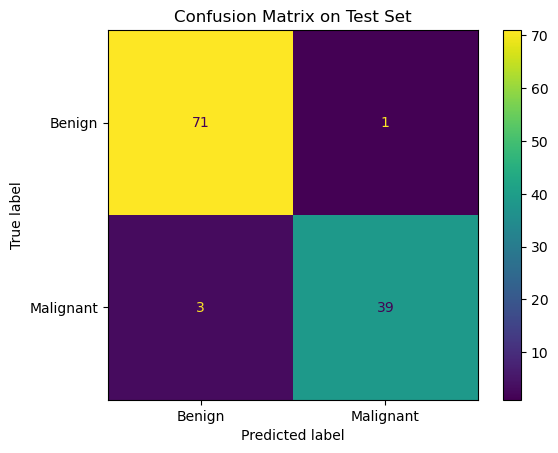

In [10]:

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_trainlog)
X_test_scaled = scaler.transform(X_testlog)

selector = SelectKBest(score_func=f_classif, k=best_f)
X_train_selected = selector.fit_transform(X_train_scaled, y_trainlog)
X_test_selected = selector.transform(X_test_scaled)

final_features = X.columns[selector.get_support()]
print("Selected features:", list(final_features))

knn_final = KNeighborsClassifier(n_neighbors=best_k)
knn_final.fit(X_train_selected, y_trainlog)
y_pred = knn_final.predict(X_test_selected)

accuracy = accuracy_score(y_testlog, y_pred)
print("Test Accuracy:", accuracy)

cm = confusion_matrix(y_testlog, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign", "Malignant"])
disp.plot()
plt.title("Confusion Matrix on Test Set")
plt.show()


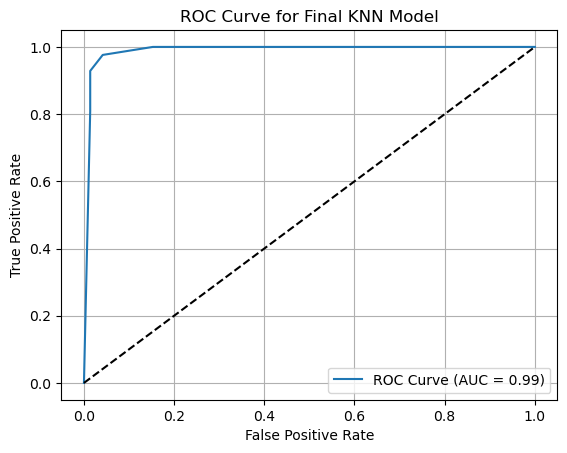

In [16]:
from sklearn.metrics import roc_curve, auc

y_prob = knn_final.predict_proba(X_test_selected)[:, 1]

fpr, tpr, _ = roc_curve(y_testlog, y_prob)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Final KNN Model")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
